In [34]:
# Import necessary packages
# Note, need to run the following in Terminal / Command :  pip install geopy
import math
import pandas as pd
import numpy as np
import scipy
import datetime as dt
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
%matplotlib inline 

In [3]:
# Load September 2014 data in Pandas dataframe
import requests, zipfile, StringIO
r = requests.get('https://s3.amazonaws.com/tripdata/201409-citibike-tripdata.zip')
z = zipfile.ZipFile(StringIO.StringIO(r.content))
data = pd.read_csv(z.open('201409-citibike-tripdata.csv'))

print data.head()

   tripduration          starttime           stoptime  start station id  \
0          2828  9/1/2014 00:00:25  9/1/2014 00:47:33               386   
1           368  9/1/2014 00:00:28  9/1/2014 00:06:36               387   
2          2201  9/1/2014 00:00:40  9/1/2014 00:37:21               386   
3           322  9/1/2014 00:00:41  9/1/2014 00:06:03               167   
4          1693  9/1/2014 00:00:59  9/1/2014 00:29:12               223   

        start station name  start station latitude  start station longitude  \
0     Centre St & Worth St               40.714948               -74.002345   
1  Centre St & Chambers St               40.712733               -74.004607   
2     Centre St & Worth St               40.714948               -74.002345   
3          E 39 St & 3 Ave               40.748901               -73.976049   
4          W 13 St & 7 Ave               40.737815               -73.999947   

   end station id               end station name  end station latitude  \


In [4]:
# Get day of the week (1 = Monday, 2 = Tuesday, etc.) for starttime
# Create indicator for weekend (based on starttime) (1 == weekend)

temp = pd.DatetimeIndex(data['starttime'])
data['weekend_indicator'] = pd.get_dummies(temp.weekday >= 5)[1]

print data.head()

   tripduration          starttime           stoptime  start station id  \
0          2828  9/1/2014 00:00:25  9/1/2014 00:47:33               386   
1           368  9/1/2014 00:00:28  9/1/2014 00:06:36               387   
2          2201  9/1/2014 00:00:40  9/1/2014 00:37:21               386   
3           322  9/1/2014 00:00:41  9/1/2014 00:06:03               167   
4          1693  9/1/2014 00:00:59  9/1/2014 00:29:12               223   

        start station name  start station latitude  start station longitude  \
0     Centre St & Worth St               40.714948               -74.002345   
1  Centre St & Chambers St               40.712733               -74.004607   
2     Centre St & Worth St               40.714948               -74.002345   
3          E 39 St & 3 Ave               40.748901               -73.976049   
4          W 13 St & 7 Ave               40.737815               -73.999947   

   end station id               end station name  end station latitude  \


In [9]:
#Caluculate Manhattan distance based on change in latitude and longitude

def distance(startlat,startlon,endlat,endlon):
    changelat=abs((startlat)-(endlat))
    changelon = abs((startlon)-(endlon))
    distance = (abs(changelat*110.574*.63127) + abs(changelon*111.320*math.cos(40.7451677)*.63127))
    return distance

data['distance']=distance((data['start station latitude']),(data['start station longitude']),(data['end station latitude']),(data['end station longitude']))
data['mph']=data['distance']/(data['tripduration']/3600)

# Calculate speed using dist (in miles) / (tripduration (in sec) / 3600 )
# This assumes we care about the min. distance travelled (most efficient route which may not exist due to road structure)

print data.head()

   tripduration          starttime           stoptime  start station id  \
0          2828  9/1/2014 00:00:25  9/1/2014 00:47:33               386   
1           368  9/1/2014 00:00:28  9/1/2014 00:06:36               387   
2          2201  9/1/2014 00:00:40  9/1/2014 00:37:21               386   
3           322  9/1/2014 00:00:41  9/1/2014 00:06:03               167   
4          1693  9/1/2014 00:00:59  9/1/2014 00:29:12               223   

        start station name  start station latitude  start station longitude  \
0     Centre St & Worth St               40.714948               -74.002345   
1  Centre St & Chambers St               40.712733               -74.004607   
2     Centre St & Worth St               40.714948               -74.002345   
3          E 39 St & 3 Ave               40.748901               -73.976049   
4          W 13 St & 7 Ave               40.737815               -73.999947   

   end station id               end station name  end station latitude  \


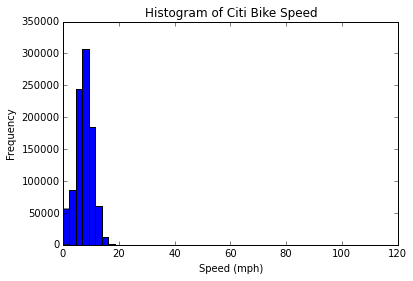

In [76]:
plt.hist(data['mph'], bins=50)
plt.xlabel('Speed (mph)')
plt.ylabel('Frequency')
plt.title('Histogram of Citi Bike Speed')
plt.show()

In [11]:
# Replace column header name spaces with underscores
cols = data.columns
cols = cols.map(lambda x: x.replace(' ', '_') if isinstance(x, (str, unicode)) else x)
data.columns = cols

print data.head()

   tripduration          starttime           stoptime  start_station_id  \
0          2828  9/1/2014 00:00:25  9/1/2014 00:47:33               386   
1           368  9/1/2014 00:00:28  9/1/2014 00:06:36               387   
2          2201  9/1/2014 00:00:40  9/1/2014 00:37:21               386   
3           322  9/1/2014 00:00:41  9/1/2014 00:06:03               167   
4          1693  9/1/2014 00:00:59  9/1/2014 00:29:12               223   

        start_station_name  start_station_latitude  start_station_longitude  \
0     Centre St & Worth St               40.714948               -74.002345   
1  Centre St & Chambers St               40.712733               -74.004607   
2     Centre St & Worth St               40.714948               -74.002345   
3          E 39 St & 3 Ave               40.748901               -73.976049   
4          W 13 St & 7 Ave               40.737815               -73.999947   

   end_station_id               end_station_name  end_station_latitude  \


In [81]:
#Do a one-sided t-test to compare speeds during weekdays and weekends.
results=scipy.stats.ttest_ind(data[data['weekend_indicator']==1]['mph'],data[data['weekend_indicator']==0]['mph'],equal_var=False)
print results

Ttest_indResult(statistic=-113.53191071635105, pvalue=0.0)


In [83]:
#Filter out distances of less than 0.25 miles, and do a one-sided t-test to compare speeds during weekdays and weekends.
#These tripes may be loops, so they have speed 0.
results2=scipy.stats.ttest_ind(data[(data['weekend_indicator']==1) & (data['distance']<=0.25)]['mph'],data[(data['weekend_indicator']==0) & (data['distance']<=0.25)]['mph'],equal_var=False)
print results2

Ttest_indResult(statistic=-20.531325227987388, pvalue=5.8553549486959073e-93)


In [82]:
def ttest_results(p, alpha):
    #divide p by two becuase we are used a one sided t test
    p = p/2
    if p < alpha:
       print('Our null hypothesis is rejected, as our p value of %s is less than our alpha of %s.')%(p,alpha)
    else:
       print('Our null hypothesis is NOT rejected ( p value of %s is greater than our alpha of %s)')%(p,alpha)
       

ttest_results(results[1], alpha = 0.05)

Our null hypothesis is rejected, as our p value of 0.0 is less than our alpha of 0.05.


In [68]:
# Run regression assuming normal/Gaussian distribution
mod = smf.ols(formula='mph ~ weekend_indicator + C(gender) + birth_year + C(usertype)', data = data).fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:                    mph   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     6028.
Date:                Wed, 07 Oct 2015   Prob (F-statistic):               0.00
Time:                        12:11:55   Log-Likelihood:            -2.0968e+06
No. Observations:              854562   AIC:                         4.194e+06
Df Residuals:                  854556   BIC:                         4.194e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------
Intercept             

In [75]:
#We get a different t-statistic for weekend_indicator in our OLS regression
#because it also evaluates other variables.